In [ ]:
!git clone https://github.com/kdhingra307/temp

Cloning into 'temp'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 65 (delta 10), reused 65 (delta 10), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [ ]:
cd temp

/content/temp


In [ ]:
mv PixelCNN/pixelcnn/ ./

In [ ]:
!git clone https://github.com/kdhingra307/PixelCNN

Cloning into 'PixelCNN'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 378 (delta 86), reused 102 (delta 36), pack-reused 215
Receiving objects: 100% (378/378), 23.25 MiB | 26.66 MiB/s, done.
Resolving deltas: 100% (214/214), done.


In [ ]:
import numpy as np
from scipy.io import loadmat as import_mat
from matplotlib import pyplot as plt
from matplotlib.cm import viridis as cm_viridis
import torch
from glob import glob
from tqdm import tqdm_notebook as tqdm
from torchvision import transforms
from datetime import datetime
from PIL import Image
from collections import defaultdict
import torch
import argparse
from importlib import reload
from torch.nn.utils import clip_grad_norm_
from pixelcnn import PixelCNN

In [ ]:
batch_size = 16

In [ ]:
from models import ModelBuilder, SegmentationModule

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

task_type = "pixelcnn_logistic"
time_date = "{}".format(datetime.now())
tensorboard_writer = SummaryWriter("../drive/MyDrive/acv_project/log/{}/{}".format(task_type, time_date))

In [ ]:
!wget https://groups.csail.mit.edu/vision/datasets/ADE20K/ADE20K_2016_07_26.zip
!unzip -q ADE20K_2016_07_26.zip

--2020-12-21 19:59:33--  https://groups.csail.mit.edu/vision/datasets/ADE20K/ADE20K_2016_07_26.zip
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4051732024 (3.8G) [application/zip]
Saving to: ‘ADE20K_2016_07_26.zip’

ADE20K_2016_07_26.z 100%[===================>]   3.77G  8.70MB/s    in 4m 5s   

2020-12-21 20:03:38 (15.8 MB/s) - ‘ADE20K_2016_07_26.zip’ saved [4051732024/4051732024]



In [ ]:
def get_files(sett):
    files = glob("./ADE20K_2016_07_26/images/{}/*/*/*[jpg,png]".format(sett))

    output = []
    for e in files:
        if (e.split(".")[-1] == "jpg"):
            output.append(e)
    
    return output

validation_files = get_files("validation")

for e in validation_files:
    assert e.split(".")[-1] == "jpg"


print(len(validation_files))

train_files = get_files("training")

for e in train_files:
    assert e.split(".")[-1] == "jpg"


print(len(train_files))

1524
15417


In [ ]:
class BrainDataset(torch.utils.data.Dataset):
    
    def __init__(self, input_files):
        self.files = input_files
        self.resize = transforms.Compose([transforms.Resize(256),
                                          transforms.RandomCrop((256, 256))])
        self.target = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])
        self.tensor = transforms.ToTensor()
        self.inpt = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.449, 0.449, 0.449], std=[0.226, 0.226, 0.226]),
                        ])
        self.inpt2 = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.449, 0.449, 0.449], std=[0.226, 0.226, 0.226]),
                        ])
        self.annotation = lambda x : x.replace("images", "annotations").replace("jpg", "png")
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        inpt2 = Image.open(self.files[index]).convert("YCbCr")
        inpt = self.resize(inpt2)
        
        target = (self.tensor(inpt.resize((28, 28))) - 0.5 / 0.5) 
        
        # pix_inpt = self.target(scaled)[0].unsqueeze(0)
                  
        return {
            "input" : self.inpt(inpt),
            "target" : target[1:],
            "pix_inpt" : target[:1],
        }
        
# files = glob("./crowdsource_images-00000-of-00010/*.jpg")

train_dataset = BrainDataset(train_files)
val_dataset = BrainDataset(validation_files)

train_sampler = torch.utils.data.DataLoader(train_dataset,num_workers=3, pin_memory=True, batch_size=batch_size, shuffle=True)
val_sampler = torch.utils.data.DataLoader(val_dataset, num_workers=3, pin_memory=True, batch_size=batch_size, shuffle=True)

In [ ]:
class cfg:
    causal_ksize = 7
    hidden_ksize = 5
    color_levels = 35
    hidden_fmaps = 70
    out_hidden_fmaps = 256
    hidden_layers = 10

In [ ]:
class pixelcolor(torch.nn.Module):
    
    def __get_pixelcnn__(self):
        return PixelCNN(cfg)
    
    def __conditioning__(self):
        return torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=3, stride=1, in_channels=1024, out_channels=512, padding=1),
            torch.nn.BatchNorm2d(num_features=512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_size=3, stride=1, in_channels=512, out_channels=128, padding=0),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_size=3, stride=1, in_channels=128, out_channels=69, padding=0),
            torch.nn.BatchNorm2d(num_features=69),
            torch.nn.Tanh()).to(self.device)
    
    def __backbone__(self):
      backbone = ModelBuilder.build_encoder(
                  arch="resnet101dilated",
                  fc_dim=2048,
                  weights="")
      for e in backbone.parameters():
          e.require_grad = False
      backbone.layer4 = torch.nn.Identity()
      return backbone

    
    def __init__(self):
        super(pixelcolor, self).__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.resnet = self.__backbone__()
        self.conditioning = self.__conditioning__()
        self.pixelcnn = self.__get_pixelcnn__()

        self.pixelpost = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=70, out_channels=256, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=256, out_channels=70, kernel_size=3, padding=1)
        )

    
    def forward(self, X, scaled, target):
        X = self.resnet(X)[0]
        lf = self.conditioning(X)
        lf = torch.cat([lf, scaled], axis=1)
        target = target/31
        decoded = self.pixelcnn(target, lf)
        decoded = decoded.reshape([X.shape[0], 70, scaled.shape[2], scaled.shape[3]])
        post_pixel = self.pixelpost(decoded)

        return {
            "decoded" : decoded,
            "post_pixel" : post_pixel
        }
    
    def random(self, images):
        mask = (self.random_mask > 0.5).int()
        return images * (1-mask)  + mask * self.random_mask
    
    def sampling(self, X, scaled, target, decoder=False):
        height, width = scaled.shape[-2:]
        with torch.no_grad():
          X = self.resnet(X)[0]
          lf = self.conditioning(X)
          gen_embed = torch.cat([lf, scaled], axis=1)

          samples = torch.zeros((X.shape[0], 2, height, width), dtype=torch.float32, device=nn.device)
          if decoder:
            decoder_inpt = torch.zeros((X.shape[0], 32, 2, height, width), dtype=torch.float32, device=nn.device)
          
          for i in range(height):
              for j in range(width):
                  for k in range(2):
                    otpt = nn.pixelcnn(samples, gen_embed).reshape([X.shape[0], 32, 2, 28, 28])
                    next_sample = torch.softmax(otpt, dim=1)
                    pixel_probs = next_sample[:,:,k,i,j]
                    if decoder:
                        decoder_inpt[:, :, k, i, j] = otpt[:,:,k,i,j]
                    # sampled_levels = torch.multinomial(pixel_probs, 1).squeeze().float() / 31
                    sampled_levels = torch.argmax(pixel_probs, axis=1).squeeze().float()/31
                    samples[:, k, i, j] = sampled_levels
        
        output = samples

        if decoder:
            output = (samples, torch.argmax(self.pixelpost(decoder_inpt.reshape([X.shape[0], 64, 28, 28])).reshape((X.shape[0], 32, 2, 28, 28)), axis=1))
        
        return output


In [ ]:
nnn = pixelcolor()

In [ ]:
nn = nnn.to(nnn.device)

In [ ]:
def log_sum_exp(x):
    """ numerically stable log_sum_exp implementation that prevents overflow """
    # TF ordering
    axis  = len(x.size()) - 1
    m, _  = torch.max(x, dim=axis)
    m2, _ = torch.max(x, dim=axis, keepdim=True)
    return m + torch.log(torch.sum(torch.exp(x - m2), dim=axis))


def log_prob_from_logits(x):
    """ numerically stable log_softmax implementation that prevents overflow """
    # TF ordering
    axis = len(x.size()) - 1
    m, _ = torch.max(x, dim=axis, keepdim=True)
    return x - m - torch.log(torch.sum(torch.exp(x - m), dim=axis, keepdim=True))


softplus = torch.nn.Softplus()

def discretized_mix_logistic_loss(l, x):
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    # Pytorch ordering
    x = x.permute(0, 2, 3, 1)
    l = l.permute(0, 2, 3, 1)
    xs = [int(y) for y in x.size()]
    ls = [int(y) for y in l.size()]
   
    nr_mix =  10
    
    logit_probs = l[:, :, :, :1*nr_mix]
    l = l[:, :, :, 1*nr_mix:].contiguous().view(xs + [nr_mix * 3])
    means = l[:, :, :, :, :nr_mix]
    
    log_scales = torch.clamp(l[:, :, :, :, nr_mix:2 * nr_mix], min=-7.)
   
    coeffs = torch.tanh(l[:, :, :, :, 2 * nr_mix:3 * nr_mix])
    
    x = x.contiguous()
    x = x.unsqueeze(-1) + torch.autograd.Variable(torch.zeros(xs + [nr_mix]).cuda(), requires_grad=False)
    m2 = (means[:, :, :, 1, :] + coeffs[:, :, :, 0, :]
                * x[:, :, :, 0, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    means = torch.cat((means[:, :, :, 0, :].unsqueeze(3), m2), dim=3)
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = torch.sigmoid(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = torch.sigmoid(min_in)
    # log probability for edge case of 0 (before scaling)
    log_cdf_plus = plus_in - softplus(plus_in)
    # log probability for edge case of 255 (before scaling)
    log_one_minus_cdf_min = -softplus(min_in)
    cdf_delta = cdf_plus - cdf_min  # probability for all other cases
    mid_in = inv_stdv * centered_x
    # log probability in the center of the bin, to be used in extreme cases
    # (not actually used in our code)
    log_pdf_mid = mid_in - log_scales - 2. * softplus(mid_in)

    # now select the right output: left edge case, right edge case, normal
    # case, extremely low prob case (doesn't actually happen for us)

    # this is what we are really doing, but using the robust version below for extreme cases in other applications and to avoid NaN issue with tf.select()
    # log_probs = tf.select(x < -0.999, log_cdf_plus, tf.select(x > 0.999, log_one_minus_cdf_min, tf.log(cdf_delta)))

    # robust version, that still works if probabilities are below 1e-5 (which never happens in our code)
    # tensorflow backpropagates through tf.select() by multiplying with zero instead of selecting: this requires use to use some ugly tricks to avoid potential NaNs
    # the 1e-12 in tf.maximum(cdf_delta, 1e-12) is never actually used as output, it's purely there to get around the tf.select() gradient issue
    # if the probability on a sub-pixel is below 1e-5, we use an approximation
    # based on the assumption that the log-density is constant in the bin of
    # the observed sub-pixel value
    
    inner_inner_cond = (cdf_delta > 1e-5).float()
    inner_inner_out  = inner_inner_cond * torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1. - inner_inner_cond) * (log_pdf_mid - np.log(127.5))
    inner_cond       = (x > 0.999).float()
    inner_out        = inner_cond * log_one_minus_cdf_min + (1. - inner_cond) * inner_inner_out
    cond             = (x < -0.999).float()
    log_probs        = cond * log_cdf_plus + (1. - cond) * inner_out
    log_probs        = torch.sum(log_probs, dim=3) + log_prob_from_logits(logit_probs)
    
    return -torch.sum(log_sum_exp(log_probs))

In [ ]:
import torch.optim as optim

criterion = discretized_mix_logistic_loss
optimizer = optim.Adam(nn.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.7)

In [ ]:
plots = []
running_loss = 0.
controller = tqdm(total=int(len(train_dataset) * 10/batch_size))

best_val_loss = 0
epoch = 0
while epoch < 40:
    train_loss = []
    train_acc = []
    for each_batch_sample in train_sampler:
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = nn(each_batch_sample['input'].to(nn.device), each_batch_sample['pix_inpt'].to(nn.device), each_batch_sample['target'].to(nn.device))
        CbCr_target = each_batch_sample['target'].to(nn.device, non_blocking=True)
        loss = criterion(outputs['decoded'], CbCr_target)
        loss += criterion(outputs['post_pixel'], CbCr_target)
        loss.backward()
        
        clip_grad_norm_(nn.parameters(), 2)
        optimizer.step()
        scheduler.step()
        
        
        running_loss += loss.item()
        controller.update(1)
        controller.set_postfix({"loss":running_loss/controller.n})
        train_loss.append(loss.item())
        
        # acc = np.count_nonzero(outputs['post_pixel'].argmax(1).detach().cpu().numpy() == CbCr_target.cpu().numpy())/np.prod(CbCr_target.shape)
        # train_acc.append(acc)
        
        
        tensorboard_writer.add_scalar("loss/batch/train", loss.item(), controller.n)
        # tensorboard_writer.add_scalar("acc/batch/train", acc, controller.n)
        
    
        
    tensorboard_writer.add_scalar("loss/epoch/train", np.mean(train_loss), epoch)
    # tensorboard_writer.add_scalar("acc/epoch/train", np.mean(train_acc), epoch)

    with torch.no_grad():
        val_loss = []
        val_acc = []
        for each_batch_sample in val_sampler:
            outputs = nn(each_batch_sample['input'].to(nn.device), each_batch_sample['pix_inpt'].to(nn.device), each_batch_sample['target'].to(nn.device))
            CbCr_target = each_batch_sample['target'].to(nn.device, non_blocking=True)
            loss = criterion(outputs['decoded'], CbCr_target)
            loss += criterion(outputs['post_pixel'], CbCr_target)
            # acc = np.count_nonzero(outputs['post_pixel'].argmax(1).detach().cpu().numpy() == CbCr_target.cpu().numpy())
            # val_acc.append(acc/np.prod(CbCr_target.shape))
            val_loss.append(loss.item())
            
    tensorboard_writer.add_scalar("loss/epoch/val", np.mean(val_loss), epoch)
    # tensorboard_writer.add_scalar("acc/epoch/val", np.mean(val_acc), epoch)

    
    torch.save(nn.state_dict(), "../drive/MyDrive/acv_project/weights/google_4_{}_{}".format(task_type, epoch))
    
    epoch += 1
    print("Epoch {}, Train Loss {}, Val Loss {}".format(epoch, np.mean(train_loss), np.mean(val_loss)))
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1, Train Loss 169639.51149183093, Val Loss 164966.62670898438
Epoch 2, Train Loss 166332.2829437889, Val Loss 165062.14774576822
Epoch 3, Train Loss 166281.764952347, Val Loss 164998.22029622397
Epoch 4, Train Loss 166305.75742349584, Val Loss 164999.3585611979
Epoch 5, Train Loss 166317.24706626037, Val Loss 164970.2666015625
Epoch 6, Train Loss 166309.75925505706, Val Loss 165087.00703938803


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import os
from glob import glob

In [ ]:
!mkdir ../drive/MyDrive/acv_project/weights

# Fetch Random Image File for testing,

In [ ]:
!wget https://picsum.photos/256/256 -O 16.jpeg

--2020-12-21 12:40:14--  https://picsum.photos/256/256
Resolving picsum.photos (picsum.photos)... 172.67.74.163, 104.26.4.30, 104.26.5.30, ...
Connecting to picsum.photos (picsum.photos)|172.67.74.163|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://i.picsum.photos/id/379/256/256.jpg?hmac=i5J_Daw5-o2MIuqNRSWXXEVKLn4xBEYeU6A7TB84nSc [following]
--2020-12-21 12:40:14--  https://i.picsum.photos/id/379/256/256.jpg?hmac=i5J_Daw5-o2MIuqNRSWXXEVKLn4xBEYeU6A7TB84nSc
Resolving i.picsum.photos (i.picsum.photos)... 104.26.5.30, 104.26.4.30, 172.67.74.163, ...
Connecting to i.picsum.photos (i.picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘16.jpeg’

16.jpeg                 [ <=>                ]   8.27K  --.-KB/s    in 0s      

2020-12-21 12:40:19 (33.3 MB/s) - ‘16.jpeg’ saved [8469]



In [ ]:
img = Image.open(files[np.random.randint(len(files))]).resize((256, 256))

In [ ]:
gray_scale = img.convert("LA").resize([256, 256])

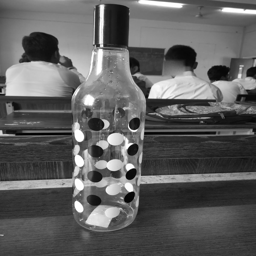

In [ ]:
gray_scale

In [ ]:
scaled_down = gray_scale.resize((28,28))

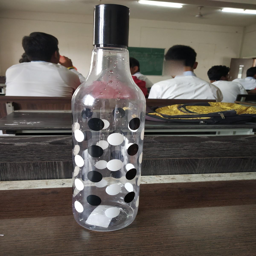

In [ ]:
img

In [ ]:
get_tensor = lambda x, s1, s2, mult: torch.Tensor((np.stack([np.array(x)[:,:,0]/256]*mult, axis=0) - s1)/s2).unsqueeze(0)

In [ ]:
nn.load_state_dict(torch.load("../drive/MyDrive/acv_project/weights/google_4_pixelcnn_29"))
nn.train()
print()

# Standard Normalization and Sampling 

In [ ]:
pix_inpt = get_tensor(scaled_down, 0.449, 0.226, 1).repeat(8, 1, 1, 1)
gray_inpt = get_tensor(gray_scale, 0.5, 0.5, 3).repeat(8, 1, 1, 1)
otpt = nn.sampling(gray_inpt.to(nn.device), pix_inpt.to(nn.device), torch.zeros([8,2,28,28]).to(nn.device), decoder=True)

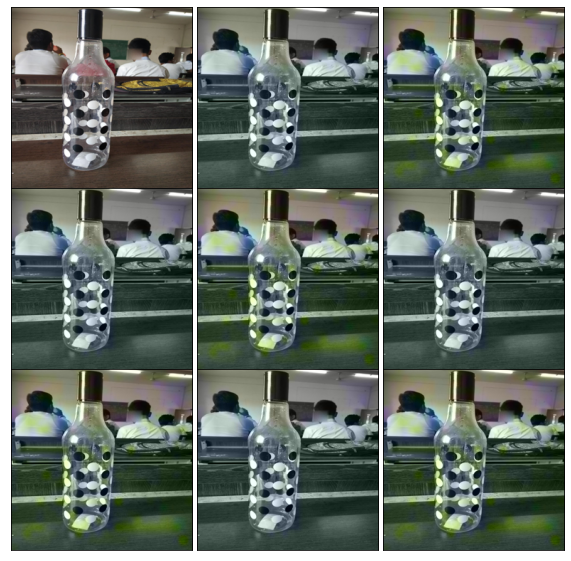

In [ ]:
_, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

ax[0,0].imshow(img)
for i in range(8):
    if i %2 ==0:
        choose_arr = otpt[0]
    else:
        choose_arr = otpt[1]/31
    rescaled_otpt = np.array(Image.fromarray(np.transpose(choose_arr[i].detach().cpu().numpy()*8*31, [1,2,0]).astype(np.uint8)).resize((256, 256)))
    ax[(i+1)//3, (i+1)%3].imshow(Image.fromarray(np.concatenate([np.expand_dims(np.array(gray_scale)[:,:,0], axis=-1), rescaled_otpt], axis=-1).astype(np.uint8), mode="YCbCr").convert("RGB"))
plt.setp(ax, xticks=[], yticks=[])
plt.subplots_adjust(wspace=0, hspace=0)

torch.Size([8, 2, 28, 28])

In [ ]:
!wget https://storage.googleapis.com/open-images-extended/extended-crowdsourced-images-0.tar.gz

--2020-12-21 12:07:08--  https://storage.googleapis.com/open-images-extended/extended-crowdsourced-images-0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9170458279 (8.5G) [application/gzip]
Saving to: ‘extended-crowdsourced-images-0.tar.gz’

extended-crowdsourc 100%[===================>]   8.54G  32.3MB/s    in 3m 20s  

2020-12-21 12:10:29 (43.7 MB/s) - ‘extended-crowdsourced-images-0.tar.gz’ saved [9170458279/9170458279]



In [ ]:
!tar -xzf extended-crowdsourced-images-0.tar.gz

In [ ]:
from glob import glob

In [ ]:
files = glob("./crowdsource_images-00000-of-00010/*")

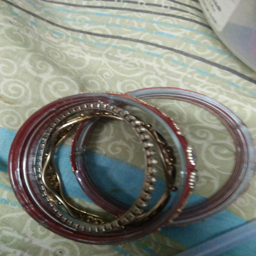

In [ ]:
Image.open(files[np.random.randint(len(files))]).resize((256, 256))

In [ ]:
!rm -rf DIV2K_train_HR*

In [ ]:
nn.load_state_dict(torch.load("../drive1/MyDrive/acv_project/weights/active_4_pixelcnn_19"))

In [ ]:
torch.save(nn.state_dict(), "../drive/MyDrive/acv_project/weights/crowd_source")